# Powerlifting records clustering analysis

    The script is used to cluster powerlifting records based on it's proximity to the world record allowing an insight 
    between different weight classes with the intent of better classifying athlete performance as beginner, intermediate, advanced and elite.

###### The used data it's from IPF openpowerlifting official site

In [1]:
import pandas as pd
import numpy as np 


#### Data filtered to include only raw full power (SBD) meets
###### Also discarted some rows that won't be used, like wilks

In [ ]:
import requests
import io
import zipfile

zip_url = "https://openpowerlifting.gitlab.io/opl-csv/files/openipf-latest.zip"

try:
    r = requests.get(zip_url, stream=True)
    r.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        # pick the first CSV (or choose by name if you prefer)
        csv_files = [n for n in z.namelist() if n.lower().endswith('.csv')]
        if not csv_files:
            raise RuntimeError("no CSV found inside downloaded zip")
        csv_name = csv_files[0]
        print("reading", csv_name, "from", zip_url)
        with z.open(csv_name) as fh:
            df = pd.read_csv(fh)
except Exception as e:
    # fallback: try local zip or local csv (keeps working when offline)
    print("download/read failed:", e)
    try:
        with zipfile.ZipFile("openipf-latest.zip") as z:
            csv_files = [n for n in z.namelist() if n.lower().endswith('.csv')]
            csv_name = csv_files[0]
            with z.open(csv_name) as fh:
                df = pd.read_csv(fh)
    except Exception as e2:
        # final fallback to old local filename
        print("fallback failed:", e2)
        df = pd.read_csv('openipf-2025-09-20-cf2e2024.csv')


reading openipf-2025-11-08/openipf-2025-11-08-c1c550e2.csv from https://openpowerlifting.gitlab.io/opl-csv/files/openipf-latest.zip


C:\Users\gatu_\AppData\Local\Temp\ipykernel_13924\1458288261.py:19: DtypeWarning: Columns (33,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fh)


In [ ]:
# df = pd.read_csv('openipf-2025-09-20-cf2e2024.csv')
# df = df.loc[(df['Equipment'] == 'Raw') & (df['Event'] == 'SBD')]
# df = df.drop(columns=['Country', 'Tested', 'State', 'Federation', 'Place', 'Date', 'MeetCountry', 'MeetState', 'MeetName',
#                       'Wilks', 'Glossbrenner', 'ParentFederation', 'MeetTown', 'Sanctioned', 'BodyweightKg', 'Equipment','Event'])
# print(df.head())

C:\Users\gatu_\AppData\Local\Temp\ipykernel_13924\3430104454.py:1: DtypeWarning: Columns (33,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('openipf-2025-09-20-cf2e2024.csv')


              Name Sex   Age AgeClass BirthYearClass   Division WeightClassKg  \
0   Kate MacDonald   F  41.0    40-44          40-49  Masters 1           84+   
1        Uyen Pham   F  36.0    35-39          24-39       Open            57   
2         Lily Ngo   F  24.0    24-34          24-39       Open            69   
3      Kat Trinder   F  39.0    35-39          24-39       Open            76   
4  Aeva Petranovic   F  25.0    24-34          24-39       Open            84   

   Squat1Kg  Squat2Kg  Squat3Kg  ...  Bench4Kg  Best3BenchKg  Deadlift1Kg  \
0     105.0     115.0     125.0  ...       NaN          67.5        145.0   
1     117.5     125.0    -130.0  ...       NaN          72.5        125.0   
2     120.0     130.0     137.5  ...       NaN          97.5        140.0   
3     120.0     130.0     135.0  ...       NaN          70.0        117.5   
4     137.5     147.5     155.0  ...       NaN          87.5        170.0   

   Deadlift2Kg  Deadlift3Kg  Deadlift4Kg  Best3Dea

## Weight classes normalization to ipf standards


In [3]:
IPF_Classes = {
    "14–18": "Sub-junior",
    "19–23": "Junior",
    "24–39": "Open",
    "40–49": "Masters I",
    "50–59": "Masters II",
    "60–69": "Masters III",
    "70-999": "Masters IV"
}
# simple mapping: normalize dash characters and replace exact / contained matches with IPF labels
ipf_map = {k.replace('–', '-'): v for k, v in IPF_Classes.items()}

def _simple_map_birthyear(s):
    if pd.isna(s):
        return np.nan
    s_norm = str(s).strip().replace('–', '-')
    # exact match first
    if s_norm in ipf_map:
        return ipf_map[s_norm]
    # if the cell contains one of the IPF keys (or vice versa), map to label
    for k, label in ipf_map.items():
        if k in s_norm or s_norm in k:
            return label
    # otherwise leave as-is
    return s_norm

df['BirthYearClass'] = df['BirthYearClass'].apply(_simple_map_birthyear)


In [ ]:
# one-hot encode BirthYearClass for df_M
expected_byc = list(ipf_map.values())  # ['Sub-junior','Junior','Open','Masters I',...]
sanitize = lambda s: re.sub(r'\W+', '_', s).strip('_')

# create dummies (fill missing with 'Unknown' so we get explicit column if needed)
byc_ohe = pd.get_dummies(df['BirthYearClass'].fillna('Unknown'), prefix='BYC')
# sanitize column names (remove spaces/special chars)
byc_ohe.columns = [re.sub(r'\W+', '_', col) for col in byc_ohe.columns]

# build expected column names 
expected_cols = ['BYC_' + sanitize(c) for c in expected_byc] + ['BYC_Unknown']
byc_ohe = byc_ohe.reindex(columns=expected_cols, fill_value=0).astype(int)

# attach to df_M
df = pd.concat([df.reset_index(drop=True), byc_ohe.reset_index(drop=True)], axis=1)

# convert original BirthYearClass to numeric category codes
cat = pd.Categorical(df['BirthYearClass'], categories=expected_byc)
df['BirthYearClass'] = cat.codes
df['BirthYearClass'] = df['BirthYearClass'].replace({-1: np.nan}).astype(float)

print("Added one-hot columns:", expected_cols)



Added one-hot columns: ['BYC_Sub_junior', 'BYC_Junior', 'BYC_Open', 'BYC_Masters_I', 'BYC_Masters_II', 'BYC_Masters_III', 'BYC_Masters_IV', 'BYC_Unknown']


## Created records map for both genres

In [5]:
df_F = df.loc[df['Sex']=='F']
#df_F.head(5)

df_M = df.loc[df['Sex']=='M']
#df_M.head(5)


F_records = {}
M_records = {}

In [6]:

print(M_records)
print(df.WeightClassKg.unique())    

#IPF
ClassesM = ["53", "59", "66", "74", "83", "93", "105", "120", "120+"]
ClassesF = ["43", "47", "52", "57", "63", "69", "76", "84", "84+"]

{}
['84+' '57' '69' '76' '84' '93' '83' '74' '120' '105' '66' '120+' '59'
 '52' '63' '47' '43' '53' '72' '56' '60' '82.5' '110' '110+' nan '90'
 '67.5' '100' '75' '125+' '125' '83+' '63+' '48' '90+' '105+' '57+' '93+'
 '72+' '140' '37' '44' '30' '40' '35' '46' '31' '39' '38' '33' '74+' '76+'
 '69+' '145' '140+' '36' '100+' '75+' '32' '87' '52+' '+' '82.5+' '85'
 '85+' '49']


#### Mens records
###### df_M / M_records

In [7]:

# Clean and filter data
        #Drop rows with incorrect classes 
df_M = df_M[df_M['WeightClassKg'].isin(ClassesM)]
        #Drop rows with missing values in WeightClassKg or TotalKg
df_M = df_M.dropna(subset=['WeightClassKg', 'TotalKg']).copy()    
        


# Get max TotalKg per allowed class
M_records = df_M.groupby('WeightClassKg')['TotalKg'].max().reset_index()

# Format as list of dicts
output = [{"Classe": row['WeightClassKg'], "Record": row['TotalKg']} for _, row in M_records.iterrows()]
print(output)

[{'Classe': '105', 'Record': 979.0}, {'Classe': '120', 'Record': 1010.0}, {'Classe': '120+', 'Record': 1112.5}, {'Classe': '53', 'Record': 559.0}, {'Classe': '59', 'Record': 670.5}, {'Classe': '66', 'Record': 742.5}, {'Classe': '74', 'Record': 842.5}, {'Classe': '83', 'Record': 900.0}, {'Classe': '93', 'Record': 919.5}]


#### Women records
###### df_F / F_records

In [8]:
# Clean and filter data
        #Drop rows with incorrect classes 
df_F = df_F[df_F['WeightClassKg'].isin(ClassesF)]
        #Drop rows with missing values in WeightClassKg or TotalKg
df_F = df_F.dropna(subset=['WeightClassKg', 'TotalKg']).copy()    
        


# Get max TotalKg per allowed class
F_records = df_F.groupby('WeightClassKg')['TotalKg'].max().reset_index()

# Format as list of dicts
output = [{"Classe": row['WeightClassKg'], "Record": row['TotalKg']} for _, row in F_records.iterrows()]
print(output)

[{'Classe': '43', 'Record': 349.5}, {'Classe': '47', 'Record': 435.0}, {'Classe': '52', 'Record': 480.0}, {'Classe': '57', 'Record': 520.0}, {'Classe': '63', 'Record': 566.0}, {'Classe': '69', 'Record': 612.5}, {'Classe': '76', 'Record': 613.0}, {'Classe': '84', 'Record': 646.0}, {'Classe': '84+', 'Record': 737.5}]


## Add Column to compare atlhete total with WeightClass World Record

##### Mens

In [9]:
#df_M #M_records
#df_F #F_records

# Create a lookup dictionary for world records
record_dict = dict(zip(M_records['WeightClassKg'], M_records['TotalKg']))

# Calculate % of WR for each athlete
df_M['%OfWR'] = df_M.apply(
    lambda x: (x['TotalKg'] / record_dict[x['WeightClassKg']]) * 100 if x['WeightClassKg'] in record_dict else None,
    axis=1
)

print(df_M['%OfWR'])
print(df_M.loc[np.isclose(df_M['%OfWR'], 100), ['Name', 'WeightClassKg','TotalKg','%OfWR']].sort_values('TotalKg'))


7         63.893420
8         58.183796
9         51.944444
10        66.944444
11        51.038576
            ...    
538895    69.023569
538896    61.666667
538897    68.515498
538898    60.265577
538899    54.831461
Name: %OfWR, Length: 333940, dtype: float64
                        Name WeightClassKg  TotalKg  %OfWR
12035           Dalton LaCoe            53    559.0  100.0
318382     Sergey Fedosienko            59    670.5  100.0
7835    Kjell Egil Bakkelund            66    742.5  100.0
7852       Austin Perkins #1            74    842.5  100.0
468901     Joseph Borenstein            83    900.0  100.0
468943        Jonathan Cayco            93    919.5  100.0
468987    Anthony McNaughton           105    979.0  100.0
469051          Rondel Hunte           120   1010.0  100.0
4320          Jesus Olivares          120+   1112.5  100.0
214091       Ray Williams #1          120+   1112.5  100.0


##### Women

In [10]:
#df_M #M_records
#df_F #F_records

# Create a lookup dictionary for world records
record_dict = dict(zip(F_records['WeightClassKg'], F_records['TotalKg']))

# Calculate % of WR for each athlete
df_F['%OfWR'] = df_F.apply(
    lambda x: (x['TotalKg'] / record_dict[x['WeightClassKg']]) * 100 if x['WeightClassKg'] in record_dict else None,
    axis=1
)

#print(df_F['%OfWR'])
print(df_F.loc[np.isclose(df_F['%OfWR'], 100), ['Name', 'WeightClassKg','TotalKg','%OfWR']].sort_values('TotalKg'))


                      Name WeightClassKg  TotalKg  %OfWR
10845       Marlit Fuentes            43    349.5  100.0
7645        Heather Connor            47    435.0  100.0
7657         Evie Corrigan            52    480.0  100.0
7680            Sara Naldi            57    520.0  100.0
468816      Meghan Scanlon            63    566.0  100.0
7745           Agata Sitko            69    612.5  100.0
4105           Agata Sitko            76    613.0  100.0
120624  Amanda Lawrence #1            84    646.0  100.0
7809     Brittany Schlater           84+    737.5  100.0


%OfWR
55.555556    1502
66.666667    1141
65.252855    1136
60.000000     997
61.990212     979
             ... 
45.413687       1
42.200358       1
89.023569       1
69.409660       1
17.364658       1
Name: count, Length: 6890, dtype: int64


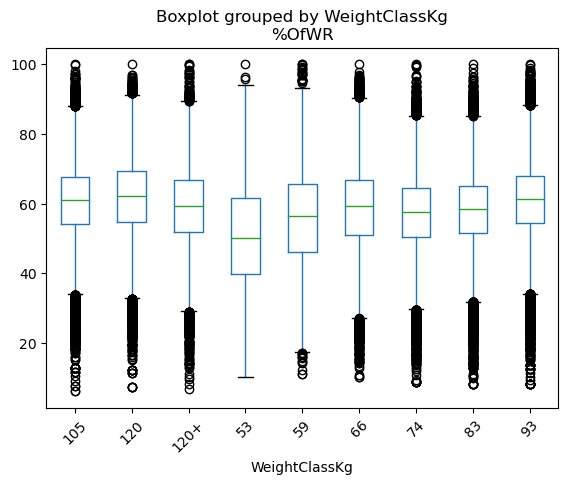

In [11]:
print(df_M['%OfWR'].value_counts())
boxplot = df_M.boxplot(column='%OfWR', by='WeightClassKg', grid=False, rot=45, fontsize=10)

## Matplotlib Graph TotalKG / %OfWR

In [12]:
import matplotlib.pyplot as plt

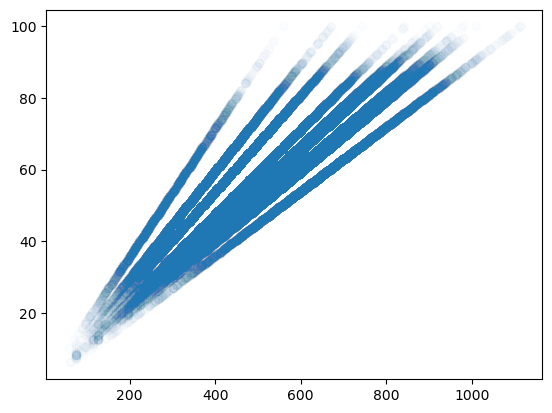

In [13]:
plt.scatter(df_M['TotalKg'], df_M['%OfWR'], alpha=0.01)

##### Plot by 1/100, so RANK 99 it's top 1% lifters

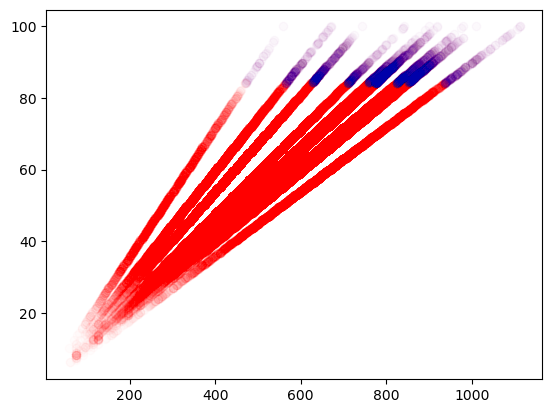

In [14]:
plt.scatter(df_M['TotalKg'], df_M['%OfWR'], alpha=0.01, color='red')

df_M['Rank'] = pd.qcut(df_M['%OfWR'], 100,
                            labels = False)


for weightClass in ClassesM:    
    df_class = df_M[df_M['WeightClassKg'] == weightClass]
    df_classHigh = df_class[df_class['Rank'] == 99]
    plt.scatter(df_classHigh['TotalKg'], df_classHigh['%OfWR'], alpha=0.01, label=weightClass, color='blue')



    

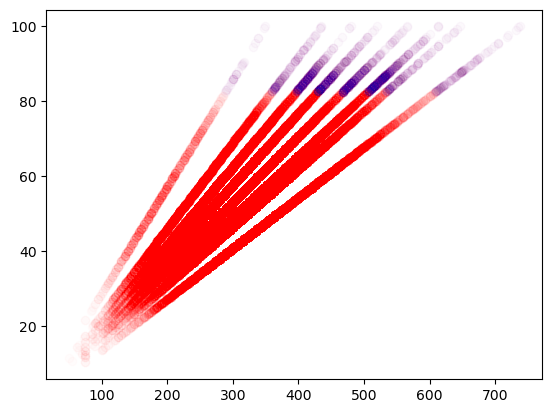

In [15]:
plt.close()
plt.clf()
plt.cla()
plt.scatter(df_F['TotalKg'], df_F['%OfWR'], alpha=0.01, color='red')

df_F['Rank'] = pd.qcut(df_F['%OfWR'], 100,
                            labels = False)

for weightClass in ClassesF:    
    df_class = df_F[df_F['WeightClassKg'] == weightClass]
    df_classHigh = df_class[df_class['Rank'] == 99]
    plt.scatter(df_classHigh['TotalKg'], df_classHigh['%OfWR'], alpha=0.01, label=weightClass, color='blue')

# Random forest classification

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 

In [17]:
   
# create one-hot encoded WC columns and attach to df_M so later X selection works reliably
wc_ohe = pd.get_dummies(df_M['WeightClassKg'], prefix='WC')
expected = ['WC_' + c for c in ClassesM]               # ensure all expected classes present
wc_ohe = wc_ohe.reindex(columns=expected, fill_value=0).astype(int)
df_M = pd.concat([df_M.reset_index(drop=True), wc_ohe.reset_index(drop=True)], axis=1)
print("one-hot columns added:", wc_ohe.columns.tolist())

# create one-hot encoded WC columns and attach to df_M so later X selection works reliably
wc_ohe = pd.get_dummies(df_F['WeightClassKg'], prefix='WC')
expected = ['WC_' + c for c in ClassesF]               # ensure all expected classes present
wc_ohe = wc_ohe.reindex(columns=expected, fill_value=0).astype(int)
df_F = pd.concat([df_F.reset_index(drop=True), wc_ohe.reset_index(drop=True)], axis=1)
print("one-hot columns added:", wc_ohe.columns.tolist())

one-hot columns added: ['WC_53', 'WC_59', 'WC_66', 'WC_74', 'WC_83', 'WC_93', 'WC_105', 'WC_120', 'WC_120+']
one-hot columns added: ['WC_43', 'WC_47', 'WC_52', 'WC_57', 'WC_63', 'WC_69', 'WC_76', 'WC_84', 'WC_84+']


In [ ]:

# one hot encode BirthYearClass for df_M


Added one-hot columns: ['BYC_Sub_junior', 'BYC_Junior', 'BYC_Open', 'BYC_Masters_I', 'BYC_Masters_II', 'BYC_Masters_III', 'BYC_Masters_IV', 'BYC_Unknown']
   BirthYearClass  BYC_Sub_junior  BYC_Junior  BYC_Open  BYC_Masters_I  \
0             1.0               0           1         0              0   
1             1.0               0           1         0              0   
2             1.0               0           1         0              0   
3             2.0               0           0         1              0   
4             3.0               0           0         0              1   

   BYC_Masters_II  BYC_Masters_III  BYC_Masters_IV  BYC_Unknown  
0               0                0               0            0  
1               0                0               0            0  
2               0                0               0            0  
3               0                0               0            0  
4               0                0               0            0  


## For better perfomance there will be 2 random forest classfiers, divided by sex.

In [28]:

X = df_M[['TotalKg', 'WC_59', 'WC_66', 'WC_74', 'WC_83', 'WC_93', 'WC_105', 'WC_120', 'WC_120+', 'BYC_Sub_junior', 'BYC_Junior', 'BYC_Open', 'BYC_Masters_I', 'BYC_Masters_II', 'BYC_Masters_III', 'BYC_Masters_IV', 'BYC_Unknown']]
y = df_M['Rank']   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=30)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))


0.9955980116188536


In [26]:
# ensure model was fitted
print("fitted:", hasattr(model, "coef_"))

# show expected features
expected = getattr(model, "feature_names_in_", X.columns)
print("expected features:", list(expected))

# build sample using X.columns, then reorder to model features (if available)
sample = pd.DataFrame([{c: 0 for c in X.columns}])

# My last comp results
sample['TotalKg'] = 558.5
sample['WC_74'] = 1
sample['BYC_Junior'] = 1
sample = sample.astype(float)

# reorder to match model if it exposes feature_names_in_
if hasattr(model, "feature_names_in_"):
    sample = sample.reindex(columns=model.feature_names_in_, fill_value=0)

print("sample columns:", list(sample.columns))
print(model.predict(sample))

fitted: False
expected features: ['TotalKg', 'WC_59', 'WC_66', 'WC_74', 'WC_83', 'WC_93', 'WC_105', 'WC_120', 'WC_120+', 'BYC_Sub_junior', 'BYC_Junior', 'BYC_Open', 'BYC_Masters_I', 'BYC_Masters_II', 'BYC_Masters_III', 'BYC_Masters_IV', 'BYC_Unknown']
sample columns: ['TotalKg', 'WC_59', 'WC_66', 'WC_74', 'WC_83', 'WC_93', 'WC_105', 'WC_120', 'WC_120+', 'BYC_Sub_junior', 'BYC_Junior', 'BYC_Open', 'BYC_Masters_I', 'BYC_Masters_II', 'BYC_Masters_III', 'BYC_Masters_IV', 'BYC_Unknown']
[73]


In [29]:

X = df_F[['TotalKg', 'WC_43', 'WC_47', 'WC_52', 'WC_57', 'WC_63', 'WC_69', 'WC_76', 'WC_84', 'WC_84+', 'BYC_Sub_junior', 'BYC_Junior', 'BYC_Open', 'BYC_Masters_I', 'BYC_Masters_II', 'BYC_Masters_III', 'BYC_Masters_IV', 'BYC_Unknown']]
y = df_F['Rank']   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=30)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

0.9888730978543451


In [21]:
# ensure model was fitted
print("fitted:", hasattr(model, "coef_"))

# show expected features
expected = getattr(model, "feature_names_in_", X.columns)
print("expected features:", list(expected))

# build sample using X.columns, then reorder to model features (if available)
sample = pd.DataFrame([{c: 0 for c in X.columns}])

# My last comp results
sample['TotalKg'] = 558.5
sample['WC_69'] = 1
sample['BYC_Junior'] = 1
sample = sample.astype(float)

# reorder to match model if it exposes feature_names_in_
if hasattr(model, "feature_names_in_"):
    sample = sample.reindex(columns=model.feature_names_in_, fill_value=0)

print("sample columns:", list(sample.columns))
print(model.predict(sample))

fitted: False
expected features: ['TotalKg', 'WC_43', 'WC_47', 'WC_52', 'WC_57', 'WC_63', 'WC_69', 'WC_76', 'WC_84', 'WC_84+', 'BYC_Sub_junior', 'BYC_Junior', 'BYC_Open', 'BYC_Masters_I', 'BYC_Masters_II', 'BYC_Masters_III', 'BYC_Masters_IV', 'BYC_Unknown']
sample columns: ['TotalKg', 'WC_43', 'WC_47', 'WC_52', 'WC_57', 'WC_63', 'WC_69', 'WC_76', 'WC_84', 'WC_84+', 'BYC_Sub_junior', 'BYC_Junior', 'BYC_Open', 'BYC_Masters_I', 'BYC_Masters_II', 'BYC_Masters_III', 'BYC_Masters_IV', 'BYC_Unknown']
[99]


# Althought for now the code only classifies the atlhete level (by % groups, (0-99)), it shall be exported and used afterwards in the development of another project.